In [1]:
#creating a directory
!mkdir ~/.kaggle

In [2]:
#using credentials to open kaggle dataset
import json
token = {"username":"nishurocks23","key":"26c5d88e7d80c0b16e9c5c7ac10f1c60"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [3]:
!cp /root/.kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: '/root/.kaggle/kaggle.json' and '/root/.kaggle/kaggle.json' are the same file


In [4]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
#downloading the zipped dataset folder on cloud
!kaggle datasets download -d crowdflower/twitter-airline-sentiment -p /content

twitter-airline-sentiment.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
#unzipping the folder
!unzip \*.zip

Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [10]:

#importing libraries for model evaluation and algorithms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import  MultinomialNB
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Now I am going to create a second model which takes into account only positive and negative tweets

In [14]:
#reading the dataframe
df=pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [15]:
#removing the neutral sentiments considering that positive and negative sentiments matter more 
df=df[df['airline_sentiment']!='neutral']
#now since neutral elements are deleted so I need to reset the indices
df.reset_index(inplace=True,drop=True)
#positive sentiments to 1 and negative to 0 
def partition(x):
    if x =='positive':
        return 1
    return 0
actualSentiment = df['airline_sentiment']
positiveNegative = actualSentiment.map(partition) 
df['Sentiment'] = positiveNegative
df['Sentiment'].value_counts() 

0    9178
1    2363
Name: Sentiment, dtype: int64

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,Sentiment
0,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1
1,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
2,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0
3,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),0
4,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),1


In [16]:
#tweets conssits of every document as an array of tokenized words which are later appended to docs 
tweets=[word_tokenize(tweet) for tweet in df['text']]
docs=[]
for j in range(0,len(tweets)):
    docs.append(tweets[j])

In [17]:
#stops includes both the stopwords and punctuations
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)

In [18]:
#to get the simple pos(part of speech) tag
from nltk.corpus import wordnet
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [19]:
#to get the pos tag for a word
from nltk import pos_tag
# now we are going to clean our data 
# we will remove stopwords and punctuations and lemmatize each document
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
def clean(words):
    output=[]
    for word in words:
        if word.lower() not in stops:
            pos=pos_tag(word)
            clean_word=lemmatizer.lemmatize(word,pos=get_simple_pos(pos[0][1]))
            output.append(clean_word.lower())
    str1=" ".join(output).encode('utf-8')        
    return str1
docs=[ clean(doc) for doc in docs]      

In [20]:
#let's look at how our texts look after cleaning and position-tag lemmatization
docs[:5]

[b"virginamerica plus 've added commercial experience ... tacky",
 b"virginamerica 's really aggressive blast obnoxious `` entertainment '' guest face amp little recourse",
 b"virginamerica 's really big bad thing",
 b"virginamerica seriously would pay 30 flight seat n't playing 's really bad thing flying va",
 b'virginamerica yes nearly every time fly vx \xe2\x80\x9c ear worm \xe2\x80\x9d \xe2\x80\x99 go away']

In [21]:
df['text'][:5]

0    @VirginAmerica plus you've added commercials t...
1    @VirginAmerica it's really aggressive to blast...
2    @VirginAmerica and it's a really big bad thing...
3    @VirginAmerica seriously would pay $30 a fligh...
4    @VirginAmerica yes, nearly every time I fly VX...
Name: text, dtype: object

In [22]:
#training involves our clean text as independent varaible and the predicted sentiments as the dependent variable 
X = np.array(docs)
Y = np.array(df['Sentiment'])
# splitting into train-test-validation set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.2, random_state=0)

In [23]:
#looking at the shapes of each of the training, test and validation sets 
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (7732,) (7732,)
X_test, Y_test (3809,) (3809,)
X_tr, Y_tr (6185,) (6185,)
X_cv, Y_cv (1547,) (1547,)


array([b'southwestair boyfriend loved imaginedragons since 2009 amp would awesome go vegas event way help',
       b'southwestair finally thx',
       b'jetblue flight delayed 2.5 hour insane every flight make nyc'],
      dtype='|S202')

In [40]:
#uses training and cross validation sets for hyperparamter tuning
def mulnb(X_train,X_cv,Y_train,Y_cv):
    best_alpha=0
    max_roc_auc=-1
    #appending auc scores of cross validation and training set in the below arrays respectively
    pred_cv = []
    pred_train = []
    alpha=[100,50,10,5,1,0.5,0.1,0.05,0.01,0.005] 
    for i in alpha[-10:]:
        mulbnb = MultinomialNB(alpha=i)
        mulbnb.fit(X_train,Y_train)
        probs = mulbnb.predict_proba(X_cv)
        prob = mulbnb.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," ------> ",auc_score_cv)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_alpha=i
    print(f"\n Best alpha Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_cv,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    #plt.plot(k,pred_cv)
    plt.title("Line Plot of ROC Curve on Train Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [25]:
#The below two lists are created to store auc and f1 scores respectively for all the vectorizations we are going to use 
AUC,F1=[],[]
def testing(X_train,Y_train,X_test,Y_test,optimal_alpha):
    bnb = MultinomialNB(optimal_alpha,fit_prior=True, class_prior=None)
    bnb.fit(X_train,Y_train)
    probs = bnb.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    AUC.append(round(roc_auc_score(Y_test,probs),2))
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    prediction=bnb.predict(X_test)
    cm=confusion_matrix(Y_test,prediction)
    cm1 = pd.DataFrame(cm , index = ['positive','negative'] , columns = ['positive','negative'])
    plt.figure(figsize = (10,10))
    ax=sns.heatmap(cm1,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
    ax.set(xlabel="Actual Sentiment", ylabel = "Predicted Sentiment")
    #printing f1 score and hamming loss
    print("f1 score for data :",metrics.f1_score(Y_test, prediction))
    F1.append(round(metrics.f1_score(Y_test, prediction),2))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))

In [26]:
#Bag Of Words Vectorization with unigrams and bigrams
count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
# In below line we get a Bag of Word model that has cleaned the text, removing non-aphanumeric characters and stop words by the fitting part and 
# a matrix where each row represents a specific text in corpus and each column represents a word in vocabulary, that is, all words found in corpus
#from the transform
bow= count_vect.fit(X_tr)
bow_train = bow.transform(X_tr)
sum_words = bow_train.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in bow.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Top 20 words with their frequencies in training set are",words_freq[:20])
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

Top 20 words with their frequencies in training set are [('united', 1846), ('flight', 1751), ('usairways', 1385), ('americanair', 1288), ('southwestair', 984), ('jetblue', 904), ('hour', 617), ('get', 591), ('service', 520), ('cancelled', 517), ('customer', 513), ('thanks', 506), ('time', 435), ('bag', 394), ('call', 386), ('help', 378), ('plane', 375), ('co', 340), ('http', 338), ('http co', 338)]
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


In [27]:
#Normalize bow data for effective model training
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


100  ------>  0.8119084861986697
50  ------>  0.8268131856556752
10  ------>  0.8584027218193213
5  ------>  0.8723251857820754
1  ------>  0.9040911556672092
0.5  ------>  0.9170182174400783
0.1  ------>  0.9373238954459032
0.05  ------>  0.9395411669905674
0.01  ------>  0.9349933903187921
0.005  ------>  0.9311724152459803

 Best alpha Value 0.05 with highest roc_auc Score is 0.9395411669905674


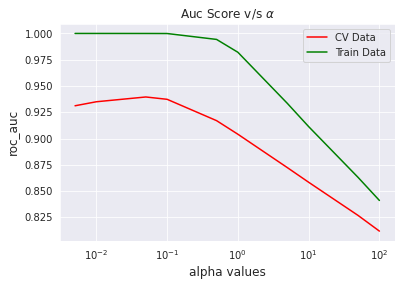

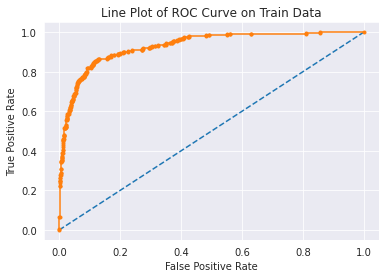

In [28]:
# find optimal value of alpha for count vectorization
mulnb(bow_train,bow_cv,Y_tr,Y_cv)

AUC Score 0.9511475432969427


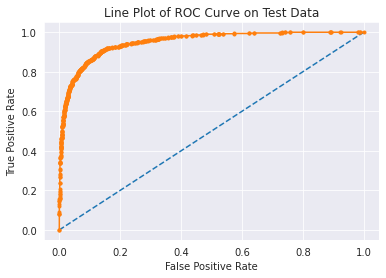

f1 score for data : 0.6926677067082684
hamming loss for data: 0.1034392228931478
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      3008
           1       0.92      0.55      0.69       801

    accuracy                           0.90      3809
   macro avg       0.91      0.77      0.82      3809
weighted avg       0.90      0.90      0.89      3809



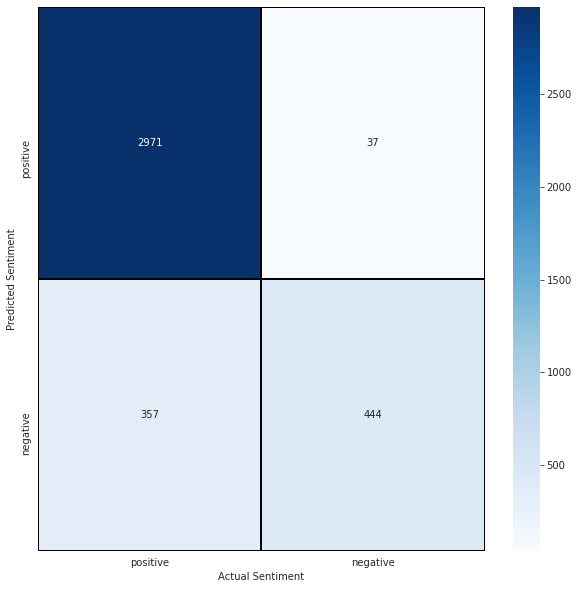

In [29]:
#optimal_alpha=0.05
testing(bow_train,Y_tr,bow_test,Y_test,optimal_alpha=0.05)

In [37]:
#TF-IDF Vectorization with unigrams and bigrams
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[10000:10010])                                                              
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

some sample features(unique words in the corpus) ['cheapslogannotmotto', 'cheat', 'cheat go', 'cheatcustomers', 'cheated', 'cheated sorry', 'check', 'check 10', 'check 24', 'check 3rd']
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


In [39]:
import pickle
pickle.dump(tf_idf_vect,open('transform.pkl','wb'))
from google.colab import files
files.download('transform.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
#displaying top 25 tfidf features
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(tfidf_train[1,:].toarray()[0],features,10)
top_tfidf

,feature,tfidf
0,asked reimbursement,0.272420
1,reimbursement something,0.272420
2,added account,0.272420
3,like mile,0.272420
4,mile added,0.272420
5,account told,0.260198
6,usairways asked,0.251525
7,something like,0.251525
8,reimbursement,0.244798
9,added,0.223903


In [32]:
#Normalize Data for effective model training
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
tfidf_train=preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (6185, 52558)
CV Data Size:  (1547, 52558)
Test Data Size:  (3809, 52558)


100  ------>  0.8454782933855788
50  ------>  0.8505711712565769
10  ------>  0.870373881489206
5  ------>  0.8817815065859812
1  ------>  0.910284769293159
0.5  ------>  0.9217977279550015
0.1  ------>  0.9353910245269206
0.05  ------>  0.9343482222327556
0.01  ------>  0.9243757669600208
0.005  ------>  0.9192460223412492

 Best alpha Value 0.1 with highest roc_auc Score is 0.9353910245269206


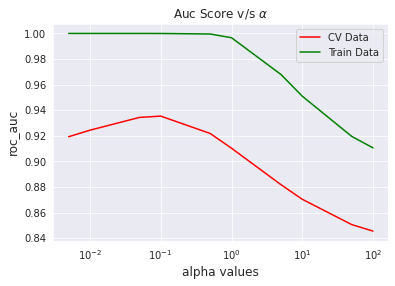

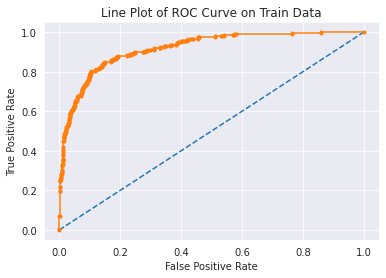

In [33]:
# find optimal_alpha for tfidf vectorization
mulnb(tfidf_train,tfidf_cv,Y_tr,Y_cv)

AUC Score 0.9479098185114351


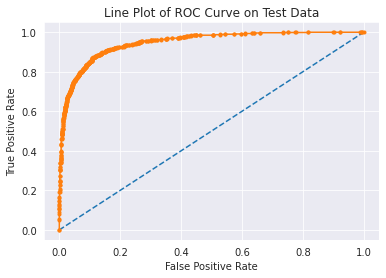

f1 score for data : 0.6465798045602607
hamming loss for data: 0.11394066684169073
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      3008
           1       0.93      0.50      0.65       801

    accuracy                           0.89      3809
   macro avg       0.91      0.74      0.79      3809
weighted avg       0.89      0.89      0.87      3809



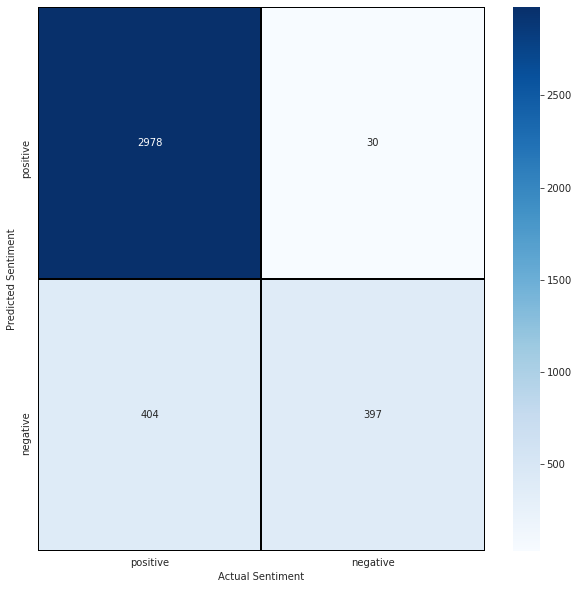

In [34]:
#using optimal alpha=0.1 for testing
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_alpha=0.1)

In [72]:
df=pd.read_csv('Tweets.csv')
#removing the neutral sentiments considering that positive and negative sentiments matter more 
df=df[df['airline_sentiment']!='neutral']
#now since neutral elements are deleted so I need to reset the indices
df.reset_index(inplace=True,drop=True)
#positive sentiments to 1 and negative to 0 
def partition(x):
    if x =='positive':
        return 1
    return 0
actualSentiment = df['airline_sentiment']
positiveNegative = actualSentiment.map(partition) 
df['Sentiment'] = positiveNegative
df['Sentiment'].value_counts() 

0    9178
1    2363
Name: Sentiment, dtype: int64

In [35]:
#Here I have displayed how the Multinomial Naive Bayes performed for both BOW and TF-IDF Vectorization
from IPython.display import display
 # intialise data of lists.
data = {'Category':['BOW Vectorization','TF-IDF Vectorization'],
        'AUC Score':AUC,
        'F1-Score':F1}
df = pd.DataFrame(data)
 
# Print the output.
display(df)      

,Category,AUC Score,F1-Score
0,BOW Vectorization,0.95,0.69
1,TF-IDF Vectorization,0.95,0.65


In [80]:
bnb=MultinomialNB()
X = tf_idf_vect.transform(df['text'])
y = df['Sentiment']
# splitting into train-test-validation set
from imblearn.combine import SMOTETomek
smtom= SMOTETomek(random_state=100)
X_smtom,y_smtom= smtom.fit_resample(X,y)
X_train, X_test, Y_train, Y_test = train_test_split(X_smtom, y_smtom, test_size=.2, random_state=0)
bnb.fit(X_train,Y_train)
sample_text = ('The movie was awesome.Everything was good about it')
k=tf_idf_vect.transform([sample_text])
bnb.predict(k)

array([1])

In [ ]:
sample_text = ('The movie was pathetic and terrible.Nothing was making any sense. Highly unacceptable.')
k=tf_idf_vect.transform([sample_text])
bnb.predict(k)

In [82]:
pickle.dump(bnb,open('nlp_model.pkl','wb'))
from google.colab import files
files.download('nlp_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>